In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from setup_utils import setup_db_connection

engine = setup_db_connection()

In [2]:

from file_utils import load_dataframes

# Define the unique filenames for loading (hash or unique IDs from when the DataFrames were saved)
stored_dfs = load_dataframes([
    "daily_vitals",
    "daily_vitals_cleaned",
    "weekly_vitals",
    "weekly_vitals_cleaned",
    "monthly_vitals",
    "monthly_vitals_cleaned",
    
])


Loaded: output_data\daily_vitals_cleaned_20250123_204446.csv
Loaded: output_data\daily_vitals_cleaned_20250123_204446.csv
Loaded: output_data\weekly_vitals_cleaned_20250123_204446.csv
Loaded: output_data\weekly_vitals_cleaned_20250123_204446.csv
Loaded: output_data\monthly_vitals_cleaned_20250123_204446.csv
Loaded: output_data\monthly_vitals_cleaned_20250123_204446.csv


In [3]:
daily_vitals = stored_dfs["daily_vitals"]
daily_vitals_cleaned = stored_dfs["daily_vitals_cleaned"]
weekly_vitals = stored_dfs["weekly_vitals"]
weekly_vitals_cleaned = stored_dfs["weekly_vitals_cleaned"]
monthly_vitals = stored_dfs["monthly_vitals"]
monthly_vitals_cleaned = stored_dfs["monthly_vitals_cleaned"]

In [4]:
daily_vitals_cleaned.head()

,charttime,heart_rate,sbp,dbp,mbp,resp_rate,temperature,spo2
0,2110-03-12,80.173913,108.350000,60.500000,74.850000,18.739130,37.128333,95.409091
1,2110-03-13,72.315789,115.176471,66.058824,81.611111,17.052632,36.976000,95.052632
2,2110-10-02,95.750000,121.611111,78.777778,94.444444,21.187500,35.780000,95.250000
3,2110-10-03,89.918919,112.880435,71.282609,84.804348,26.697368,37.048750,96.270270
4,2110-10-04,83.708333,106.958333,62.500000,76.562500,29.815789,37.175000,94.541667


In [5]:
base_query = f"""
WITH unique_patients AS (
    SELECT DISTINCT subject_id
    FROM mimiciv_hosp.patients
    LIMIT 50  -- Adjust for larger populations
),

patient_data AS (
    SELECT
        p.subject_id,
        p.gender,
        p.anchor_age AS age,
        p.dod AS date_of_death,
        a.hadm_id,
        a.admittime AS admission_time,
        a.dischtime AS discharge_time,
        i.stay_id,
        i.intime AS icu_admission_time,
        i.outtime AS icu_discharge_time,
        i.los AS icu_length_of_stay
    FROM mimiciv_hosp.patients p
    INNER JOIN mimiciv_hosp.admissions a
        ON p.subject_id = a.subject_id
    INNER JOIN mimiciv_icu.icustays i
        ON a.hadm_id = i.hadm_id
    WHERE p.subject_id IN (SELECT subject_id FROM unique_patients)
),

severity_scores AS (
    SELECT
        aps.hadm_id,
        aps.stay_id,
        aps.apsiii AS apsiii_score,
        lod.lods AS lods_score,
        oasis.oasis AS oasis_score,
        sap.sapsii AS sapsii_score,
        sirs.sirs AS sirs_score,
        sep.sepsis3
    FROM mimiciv_derived.apsiii aps
    LEFT JOIN mimiciv_derived.lods lod
        ON aps.hadm_id = lod.hadm_id AND aps.stay_id = lod.stay_id
    LEFT JOIN mimiciv_derived.oasis oasis
        ON aps.hadm_id = oasis.hadm_id AND aps.stay_id = oasis.stay_id
    LEFT JOIN mimiciv_derived.sapsii sap
        ON aps.hadm_id = sap.hadm_id AND aps.stay_id = sap.stay_id
    LEFT JOIN mimiciv_derived.sirs sirs
        ON aps.hadm_id = sirs.hadm_id AND aps.stay_id = sirs.stay_id
    LEFT JOIN mimiciv_derived.sepsis3 sep
        ON aps.hadm_id = sap.hadm_id AND aps.stay_id = sap.stay_id
    WHERE aps.hadm_id IN (SELECT hadm_id FROM patient_data)
),

vitals AS (
    SELECT
        ce.subject_id,
        ce.hadm_id,
        ce.stay_id,
        ce.charttime,
        MAX(CASE WHEN ce.itemid = 220045 THEN ce.valuenum END) AS heart_rate,
        MAX(CASE WHEN ce.itemid = 220179 THEN ce.valuenum END) AS systolic_bp,
        MAX(CASE WHEN ce.itemid = 220180 THEN ce.valuenum END) AS diastolic_bp,
        MAX(CASE WHEN ce.itemid = 220210 THEN ce.valuenum END) AS respiratory_rate,
        MAX(CASE WHEN ce.itemid = 223761 THEN ce.valuenum END) AS temperature_fahrenheit,
        MAX(CASE WHEN ce.itemid = 223762 THEN ce.valuenum END) AS temperature_celsius,
        MAX(CASE WHEN ce.itemid = 220739 THEN ce.valuenum END) AS oxygen_saturation
    FROM mimiciv_icu.chartevents ce
    WHERE ce.subject_id IN (SELECT subject_id FROM unique_patients)
    GROUP BY ce.subject_id, ce.hadm_id, ce.stay_id, ce.charttime
),

labs AS (
    SELECT
        le.subject_id,
        le.hadm_id,
        le.charttime,
        MAX(CASE WHEN le.itemid = 50882 THEN le.valuenum END) AS bilirubin,
        MAX(CASE WHEN le.itemid = 50912 THEN le.valuenum END) AS creatinine,
        MAX(CASE WHEN le.itemid = 50971 THEN le.valuenum END) AS glucose
    FROM mimiciv_hosp.labevents le
    WHERE le.subject_id IN (SELECT subject_id FROM unique_patients)
    GROUP BY le.subject_id, le.hadm_id, le.charttime
)

SELECT
    pd.*, -- Basic details of patients
    ss.apsiii_score,
    ss.lods_score,
    ss.oasis_score,
    ss.sapsii_score,
    ss.sirs_score,
    ss.sepsis3,
    v.charttime,
    v.heart_rate,
    v.systolic_bp,
    v.diastolic_bp,
    v.respiratory_rate,
    v.temperature_fahrenheit,
    v.temperature_celsius,
    v.oxygen_saturation,
    l.bilirubin,
    l.creatinine,
    l.glucose
FROM patient_data pd
LEFT JOIN severity_scores ss
    ON pd.hadm_id = ss.hadm_id AND pd.stay_id = ss.stay_id
LEFT JOIN vitals v
    ON pd.subject_id = v.subject_id
    AND pd.hadm_id = v.hadm_id
    AND pd.stay_id = v.stay_id
LEFT JOIN labs l
    ON pd.subject_id = l.subject_id
    AND pd.hadm_id = l.hadm_id
    AND v.charttime = l.charttime
ORDER BY pd.subject_id, pd.hadm_id, pd.stay_id, v.charttime;

"""

In [6]:
df = pd.read_sql(base_query, engine)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17261728 entries, 0 to 17261727
Data columns (total 28 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   subject_id              int64         
 1   gender                  object        
 2   age                     int64         
 3   date_of_death           object        
 4   hadm_id                 int64         
 5   admission_time          datetime64[ns]
 6   discharge_time          datetime64[ns]
 7   stay_id                 int64         
 8   icu_admission_time      datetime64[ns]
 9   icu_discharge_time      datetime64[ns]
 10  icu_length_of_stay      float64       
 11  apsiii_score            int64         
 12  lods_score              int64         
 13  oasis_score             int64         
 14  sapsii_score            int64         
 15  sirs_score              int64         
 16  sepsis3                 bool          
 17  charttime               datetime64[ns]
 18  

In [22]:
print(f"Number of unique values in 'gender' column: {df['gender'].nunique()}")

Number of unique values in 'gender' column: 1


In [20]:
df.info()
df['age_group'] = pd.cut(df['age'], bins=range(0, 120, 10), right=False, 
                         labels=[f"{i}-{i+9}" for i in range(0, 110, 10)])
df.info()

# Quickly review the number of people in each age group and gender
age_gender_summary = df.groupby(['age_group', 'gender']).size().reset_index(name='count')
print(age_gender_summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858320 entries, 0 to 1858319
Data columns (total 29 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   subject_id              int64         
 1   gender                  object        
 2   age                     int64         
 3   date_of_death           object        
 4   hadm_id                 int64         
 5   admission_time          datetime64[ns]
 6   discharge_time          datetime64[ns]
 7   stay_id                 int64         
 8   icu_admission_time      datetime64[ns]
 9   icu_discharge_time      datetime64[ns]
 10  icu_length_of_stay      float64       
 11  apsiii_score            int64         
 12  lods_score              int64         
 13  oasis_score             int64         
 14  sapsii_score            int64         
 15  sirs_score              int64         
 16  sepsis3                 bool          
 17  charttime               datetime64[ns]
 18  he

C:\Users\steve\AppData\Local\Temp\ipykernel_22720\4069753463.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_gender_summary = df.groupby(['age_group', 'gender']).size().reset_index(name='count')


In [16]:

df['age_group'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81+'])
age_gender_dist = df.groupby(['age_group', 'gender'], observed=False).size().unstack()

gender           F
age_group         
0-20             0
21-40            0
41-60      1858320
61-80            0
81+              0


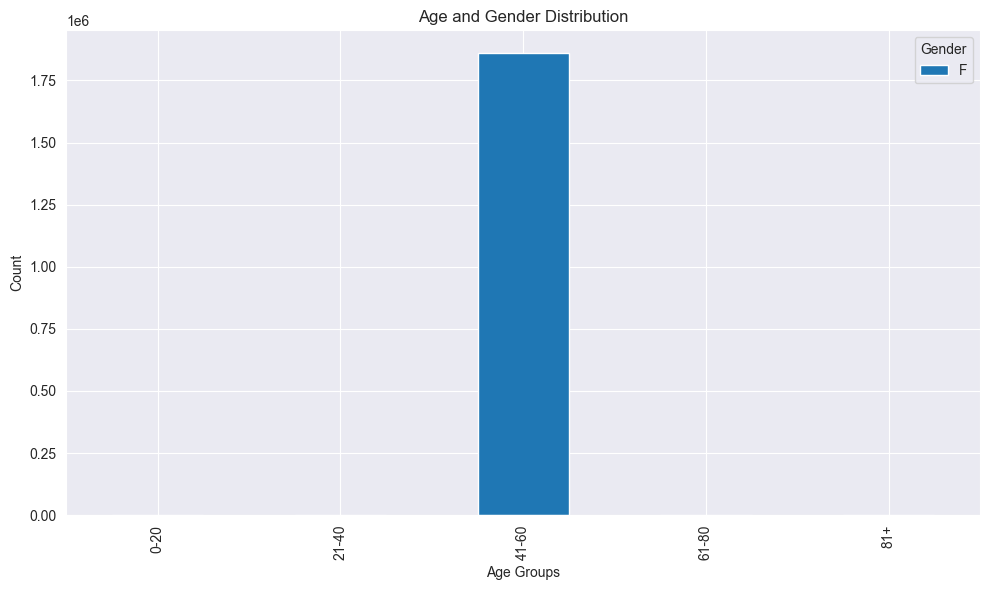

In [18]:
# Inspect the age_gender_dist DataFrame
print(age_gender_dist)

# Plot the various bins with proper visualization
import matplotlib.pyplot as plt

# Create a plot for age_gender_dist
age_gender_dist.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Age and Gender Distribution")
plt.xlabel("Age Groups")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

In [ ]:
# mortality by group
df['is_deceased'] = ~df['date_of_death'].isna()
mortality_rate = df.groupby('age_group')['is_deceased'].mean() * 100
severity_mortality = df.groupby('apsiii_score')['is_deceased'].mean()

In [ ]:
# icu los by group
los_by_age = df.groupby('age_group')['icu_length_of_stay'].mean()
los_by_severity = df.groupby('apsiii_score')['icu_length_of_stay'].mean()


In [ ]:
# general vitals
vital_summary = df[['heart_rate', 'systolic_bp', 'diastolic_bp', 'oxygen_saturation', 
                    'respiratory_rate', 'temperature_fahrenheit', 'temperature_celsius', 
                    'bilirubin', 'creatinine']].describe()

In [ ]:
# lab analysis
abnormal_bilirubin = df[df['bilirubin'] > 2.0]
abnormal_creatinine = df[df['creatinine'] > 1.2]
abnormal_glucose = df[(df['glucose'] < 70) | (df['glucose'] > 140)] 